In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import ngrams, word_tokenize
from nltk.corpus import stopwords

%matplotlib inline

# cross validation 
# from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.cross_validation import train_test_split, KFold, cross_val_score

# hyper-parameter tuning
from sklearn.grid_search import GridSearchCV

# preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, OneHotEncoder

# linear models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# non-linear models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# ensemble models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

# pipeline
from sklearn.pipeline import Pipeline

# confusion matrix
from sklearn.metrics import confusion_matrix, precision_recall_curve,auc, roc_auc_score, roc_curve, recall_score, classification_report

# Load training and testing set

In [2]:
train_data = pd.read_csv("../Dataset/train.csv")
test_data = pd.read_csv("../Dataset/test.csv")

# Define stopwords

In [3]:
stop = set(stopwords.words('english'))

# Construct ngram model

Common unigrams, bigrams and trigrams are good at differentiating the two classes.

In [4]:
def feature_engineering(row):
    ngram_list = []
    
    question1 = str(row['question1'])
    question2 = str(row['question2'])
    
    # split question1 and question2 into words, and remove stopwords
    preproc_question1 = [word for word in question1.lower().split() if word not in stop]
    preproc_question2 = [word for word in question2.lower().split() if word not in stop]
    
    # obtain unigram features
    common_unigrams_len = len(set(preproc_question1).intersection(set(preproc_question2)))
    common_unigrams_ratio = float(common_unigrams_len) / max(len(set(preproc_question1).union(set(preproc_question2))),1)
    ngram_list.extend([common_unigrams_len, common_unigrams_ratio])

    # obtain bigram features 
    bigrams_question1 = [i for i in ngrams(preproc_question1, 2)]
    bigrams_question2 = [i for i in ngrams(preproc_question2, 2)]
    common_bigrams_len = len(set(bigrams_question1).intersection(set(bigrams_question2)))
    common_bigrams_ratio = float(common_bigrams_len) / max(len(set(bigrams_question1).union(set(bigrams_question2))),1)
    ngram_list.extend([common_bigrams_len, common_bigrams_ratio])

    # obtain trigram features 
    trigrams_question1 = [i for i in ngrams(preproc_question1, 3)]
    trigrams_question2 = [i for i in ngrams(preproc_question2, 3)]
    common_trigrams_len = len(set(trigrams_question1).intersection(set(trigrams_question2)))
    common_trigrams_ratio = float(common_trigrams_len) / max(len(set(trigrams_question1).union(set(trigrams_question2))),1)
    ngram_list.extend([common_trigrams_len, common_trigrams_ratio])

    return ngram_list

In [5]:
train_features = np.vstack(np.array(train_data.apply(lambda x: feature_engineering(x), axis=1))) 
test_features = np.vstack(np.array(test_data.apply(lambda x: feature_engineering(x), axis=1)))

train_target = np.array(train_data["is_duplicate"])
test_id = np.array(test_data["test_id"])

In [6]:
X_train = train_features
X_test = test_features

y_train = train_target

In [6]:
# # split under-sampled data into training and testing
# X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, test_size=0.3)

In [7]:
# Test options and evaluation metric
num_folds = 10
scoring = "log_loss"

# linear and non-linear algorithms
models = []
models.append(("LR", LogisticRegression()))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
# models.append(("SVM", SVC()))

# evaluate each model in turn
results = []
names = []

for name, model in models:
#   kfold = KFold(n_splits=num_folds, random_state=666)
  kfold = KFold(X_train.shape[0], 10, random_state=666)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: -0.537023 (0.002717)
LDA: -0.537487 (0.002884)
KNN: -1.382656 (0.230799)
CART: -0.573276 (0.016412)
NB: -1.059884 (0.015733)


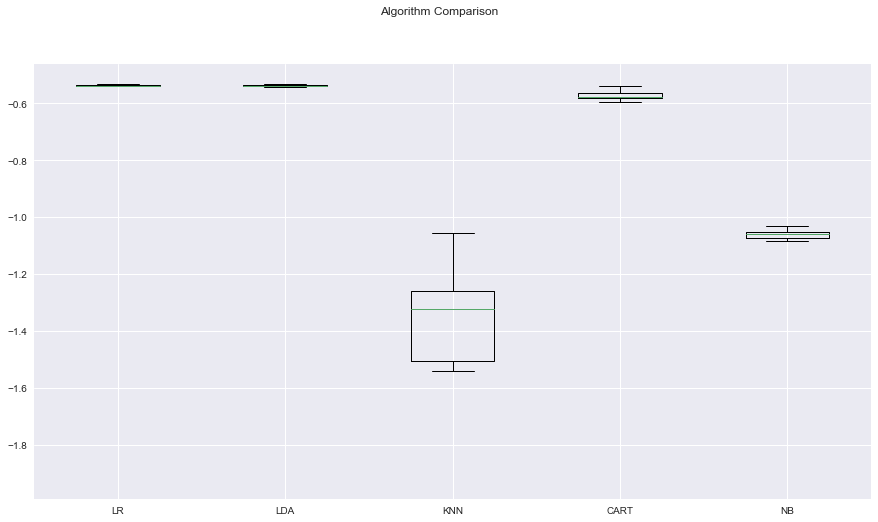

In [8]:
# Compare Algorithms
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [10]:
# ensembles
ensembles = []
ensembles.append(("AB", AdaBoostClassifier()))
ensembles.append(("GBM", GradientBoostingClassifier()))
ensembles.append(("RF", RandomForestClassifier()))
ensembles.append(("ET", ExtraTreesClassifier()))

results = []
names = []

for name, model in ensembles:
#   kfold = KFold(n_splits=num_folds, random_state=666)
  kfold = KFold(X_train.shape[0], 10, random_state=666)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

AB: -0.674655 (0.000146)
GBM: -0.453907 (0.002437)
RF: -0.483366 (0.008626)
ET: -0.526188 (0.010144)


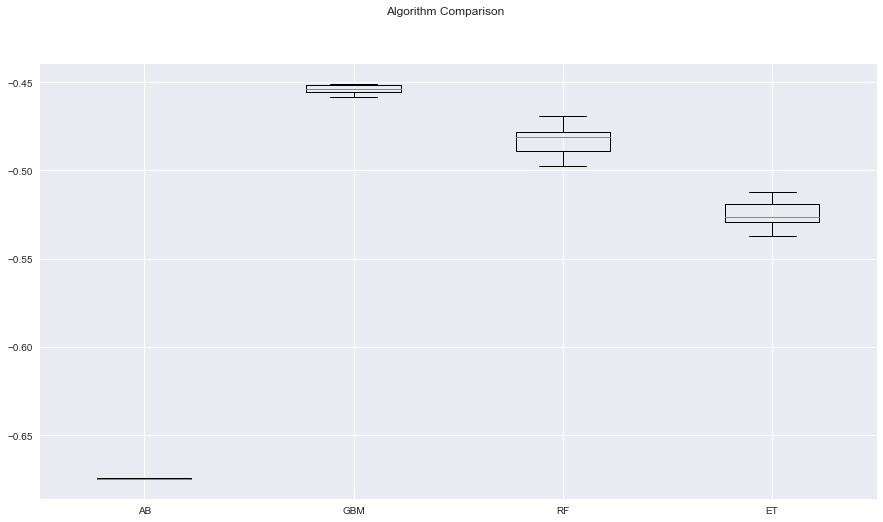

In [11]:
# Compare Algorithms
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Hyperparameter tuning via GridSearchCV

In [8]:
# tune gradient boosting classifier
learning_rate_values = [0.1, 0.01]
n_estimators_values = [100, 150, 200]
max_depth_values = [3, 4, 5]

# Best: -0.450982 using {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5}

scoring = "log_loss"

param_grid = dict(learning_rate=learning_rate_values, 
                  n_estimators=n_estimators_values, 
                  max_depth=max_depth_values)

model = GradientBoostingClassifier()

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=10, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 41.2min finished


Best: -0.450982 using {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5}


# Submission to Kaggle

In [10]:
prediction = grid_result.predict(X_test)

In [11]:
out_df = pd.DataFrame({"test_id":test_id, "is_duplicate":prediction})
out_df.to_csv("ngram_model_v1.csv", index=False)